# Create Figure 2 and its variants
KDE / histogram figures of trends across coupled and AMIP models, for different time periods.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import re
import glob
import copy
import string
from matplotlib import pyplot as plt
import scipy.stats as sstats
import cmocean
import seaborn as sns
from tqdm.notebook import tqdm

from funcs_support import get_filepaths,get_params,utility_print
from funcs_load import load_raws
from funcs_plot import hist_plot
dir_list = get_params()

In [2]:
# Load model and obs data
dss = {exp:load_raws({'varname':'prtrends','suffix':'HoAfrica','exp':exp},
                  source_dir = 'proc',force_load = True,
                     treat_multiple={'time':'earliest'},
                     subset_params = {'start_year':slice(1981,1986),'end_year':slice(2004,2014)})
       for exp in ['amip','hist-ssp245','hist-none','obs']}

In [3]:
# Merge runs that only have historical data and runs
# with historical and SSP2.45 data into the same datasets
for mod in dss['hist-none']:
    if mod in dss['hist-ssp245']:
        runs_to_concat = [run for run in dss['hist-none'][mod].run.values
                          if run not in dss['hist-ssp245'][mod].run]
        if len(runs_to_concat)>0:
            dss['hist-ssp245'][mod] = xr.concat([dss['hist-ssp245'][mod],
                                                 dss['hist-none'].sel(run=runs_to_concat)],
                                                 dim='run')
    else:
        dss['hist-ssp245'][mod] = dss['hist-none'][mod]   
del dss['hist-none']

In [4]:
# Concatenate into single dataset
def prep_for_concat(ds):
    # Helps make concatenation easier, because now the names of the runs
    # don't matter anymore (because we're not matching within models)
    ds['run'] = np.arange(0,ds.sizes['run'])
    return ds

dss = {exp:xr.concat([prep_for_concat(ds.sel(region='HoA-bimod')) for mod,ds in dss[exp].items()],
                dim = pd.Index([mod for mod in dss[exp]],name='model'))
       for exp in dss}

In [5]:
# Make sure to only keep the necessary variables (some obs products
# have more) 
vars_keep = ['prtrend','pr_std','pr_tsslope','pr_iqr','trend_length']

# trend_length gets broadcasted; cut it back down to size
for exp in dss:
    dss[exp] = dss[exp][vars_keep]
    dss[exp]['trend_length'] = dss[exp]['trend_length'].isel({k:0 for k in dss[exp].trend_length.sizes
                                                              if k not in ['start_year','end_year']},
                                                             drop=True)

In [6]:
# Get number of runs per model, at least during the Rowell period 
for exp in dss:
    dss[exp]['nruns'] = ((~np.isnan(dss[exp].prtrend.sel(start_year=1986,end_year=2004))).sum('run').
                         max(('season')))

In [7]:
# Subset to just LEs (more than 10 runs, here)
dss_les = {exp:ds.where(ds.nruns>=10,drop=True) for exp,ds in dss.items()}
# Add obs back in to make it easy (obs is dropped because 1 run per product)
dss_les['obs'] = dss['obs']

## Various figures

### Main text Fig 2

/dx02/kschwarz/project_data/future_stability/figures/figure2.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/figure2.png saved!


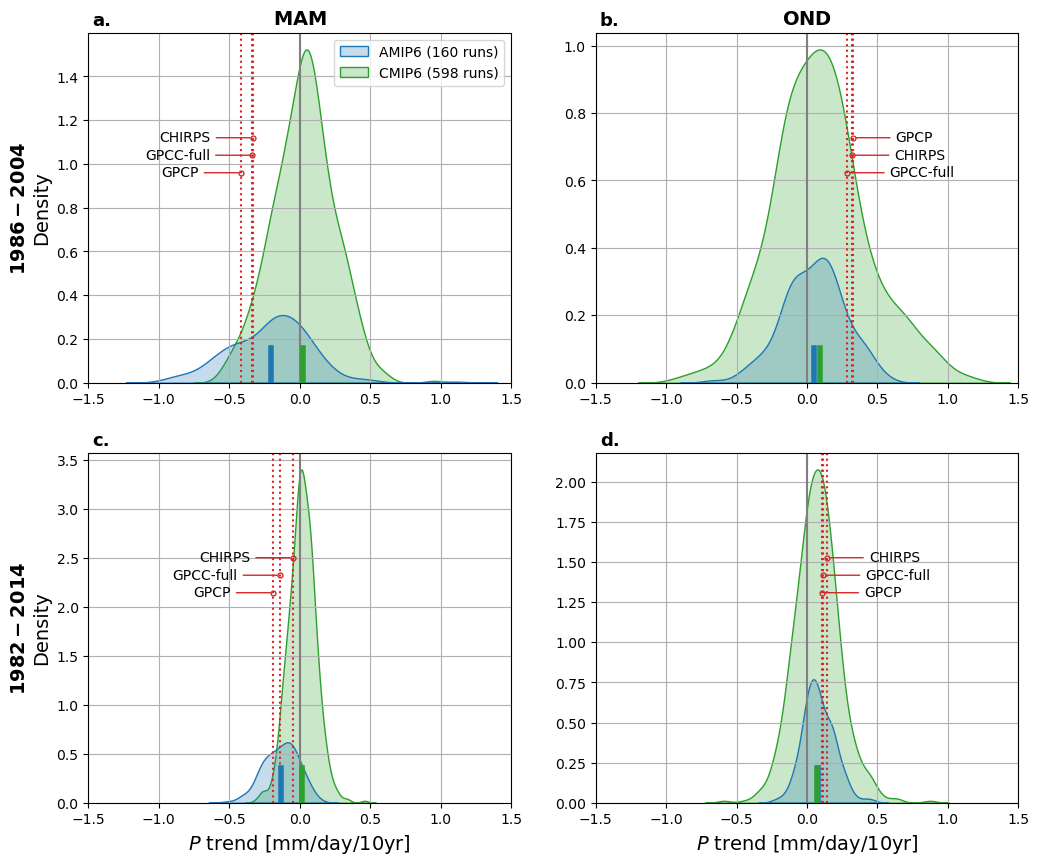

In [8]:
save_fig = True
output_fn = dir_list['figs']+'figure2'

# Which obs products to show
obs_mods = ['CHIRPS','GPCC-full','GPCP']

# Create figure
fig = plt.figure(figsize=(12,10))

# Process by plot panel
ax_params = [{'start_year':1986,'end_year':2004,'seas':'MAM','title_str':r'$\mathbf{MAM}$'},
             {'start_year':1986,'end_year':2004,'seas':'OND','title_str':r'$\mathbf{OND}$'},
             {'start_year':1982,'end_year':2014,'seas':'MAM','title_str':''},
             {'start_year':1982,'end_year':2014,'seas':'OND','title_str':''}]

for plt_idx in np.arange(0,len(ax_params)):
    ax = plt.subplot(2,2,plt_idx+1)
    ax = hist_plot(dss,**ax_params[plt_idx],fig=fig,ax=ax,text_kwargs = {'fontsize':14},plot_type='levels',
                   obs_mods = obs_mods,label_obs=True)
    
    ax.grid()
    
    if plt_idx == 0:
        sns.move_legend(ax,'upper right',title=None)
    else:
        ax.legend([],[], frameon=False)
        
    if plt_idx < 2:
        ax.set_xlabel('')
    if plt_idx % 2 > 0:
        ax.set_ylabel('')
    elif plt_idx % 2 == 0:
        ax.set_ylabel(r'$\mathbf{'+str(ax_params[plt_idx]['start_year'])+' - '+
                      str(ax_params[plt_idx]['end_year'])+'}$'+'\nDensity',
                      fontsize=14)
        
    # Subplot lettering
    ax.annotate(string.ascii_lowercase[plt_idx]+'.',
                        [0.01,1.01],xycoords='axes fraction',
                        va='bottom',ha='left',fontsize=13,fontweight='bold')
        
if save_fig:
    utility_print(output_fn)

Now, get ranges of trends for main text statistics: 

In [9]:
ds_sub = dss['obs'].sel(start_year=1986,end_year=2004,season='MAM')*10

ds_sub = ds_sub.sel(model=['CHIRPS','GPCP','GPCC-full'])

print('observational data products place the linear trend over this period between '+
 str(np.round(ds_sub.prtrend.min().values,2))+' and '+
 str(np.round(ds_sub.prtrend.max().values,2))+
 ' mm/day/decade')

print('observed trends are between the '+
 str(np.round(sstats.percentileofscore((dss['hist-ssp245'].sel(start_year=1986,end_year=2004,season='MAM')*10).prtrend.values.flatten(),
                         ds_sub.prtrend.min().values,nan_policy='omit')/100,2))+' and '+
 str(np.round(sstats.percentileofscore((dss['hist-ssp245'].sel(start_year=1986,end_year=2004,season='MAM')*10).prtrend.values.flatten(),
                         ds_sub.prtrend.max().values,nan_policy='omit')/100,2))+
 ' quantiles')

print('observational data products place the linear trend over this period between '+
 str(np.round((ds_sub.prtrend/ds_sub.pr_std).min().values,2))+' and '+
 str(np.round((ds_sub.prtrend/ds_sub.pr_std).max().values,2))+
 ' SD/decade')

observational data products place the linear trend over this period between -0.42 and -0.33 mm/day/decade
observed trends are between the 0.03 and 0.06 quantiles
observational data products place the linear trend over this period between -0.07 and -0.06 SD/decade


In [10]:
ds_sub = dss['hist-ssp245'].sel(start_year=1986,end_year=2004,season='MAM')*10
print('the CMIP6 mean over this period is '+
 str(np.round(ds_sub.prtrend.mean().values,2))+
 ' mm/day/decade')


the CMIP6 mean over this period is 0.03 mm/day/decade


In [11]:
ds_sub = dss['obs'].sel(start_year=1982,end_year=2014,season='MAM')*10

ds_sub = ds_sub.sel(model=['CHIRPS','GPCP','GPCC-full'])


print('observational data products place the linear trend over this period between '+
 str(np.round(ds_sub.prtrend.min().values,2))+' and '+
 str(np.round(ds_sub.prtrend.max().values,2))+
 ' mm/day/decade')

print('observational data products place the linear trend over this period between '+
 str(np.round((ds_sub.prtrend/ds_sub.pr_std).min().values,2))+' and '+
 str(np.round((ds_sub.prtrend/ds_sub.pr_std).max().values,2))+
 ' SD/decade')

observational data products place the linear trend over this period between -0.19 and -0.05 mm/day/decade
observational data products place the linear trend over this period between -0.03 and -0.01 SD/decade


### Supp Docs Figure S5
Showing alternate specifications:
- Using only 10 runs from LEs
- Using only the first run from each model 
- Looking at AMJ instead of MAM

In [12]:
# Create alternate obs ds, to compare 
# model 'MAM','MJJ','JJA' --> obs 'MAM'
# model 'SON','OND' --> obs 'OND'
seas_dict = {'MAM':'MAM',
             'AMJ':'MAM',
             'MJJ':'MAM',
             'SON':'OND',
             'OND':'OND'}

# Create a deepcopy to avoid modifying
# the original `dss`
dss_shift = copy.deepcopy(dss)

# Reassign obs months to compare with 
# different model months
for var in ['prtrend','pr_std']:
    for seas in seas_dict:
        dss_shift['obs'][var].loc[{'season':seas}] = dss_shift['obs'][var].sel(season = seas_dict[seas]).values

/dx02/kschwarz/project_data/future_stability/figures/figureS5.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/figureS5.png saved!


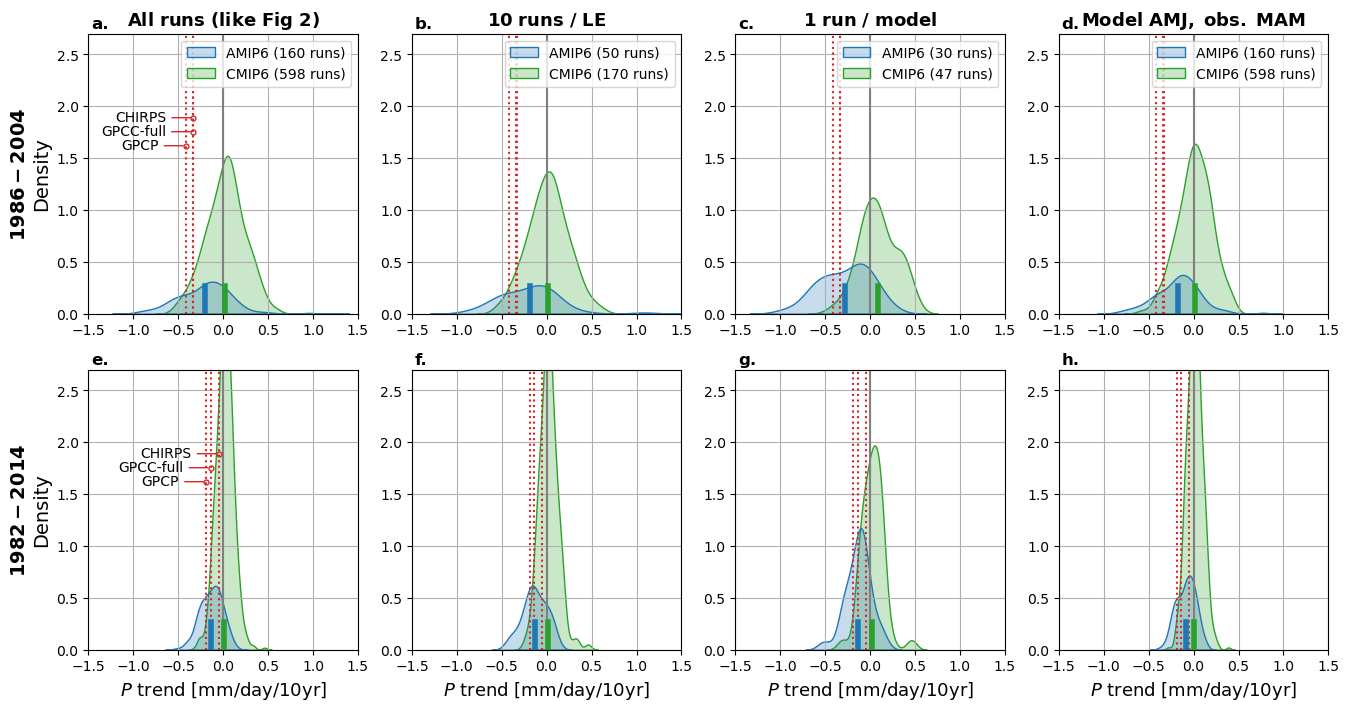

In [13]:
save_fig = True
output_fn = dir_list['figs']+'figureS5'

obs_mods = ['CHIRPS','GPCC-full','GPCP']

fig = plt.figure(figsize=(16,8))

ax_params = [{'dss_plot':dss,'seas':'MAM','title_str':r'$\mathbf{All\ runs\ (like\ Fig\ 2)}$'},
             {'dss_plot':dss_les,'nruns':10,'seas':'MAM','title_str':r'$\mathbf{10\ runs\ /\ LE}$'},
             {'dss_plot':dss,'nruns':1,'seas':'MAM','title_str':r'$\mathbf{1\ run\ /\ model}$'},
             {'dss_plot':dss_shift,'seas':'AMJ','title_str':r'$\mathbf{Model\ AMJ,\ obs.\ MAM}$'}]

ax_params = [*[{**{'start_year':1986,'end_year':2004},**ap} for ap in ax_params],
             *[{**{'start_year':1982,'end_year':2014},**ap} for ap in ax_params]]
ncols = 4

for x in np.arange(ncols,len(ax_params)):
    ax_params[x]['title_str'] = ''

for plt_idx in np.arange(0,len(ax_params)):
    ax = plt.subplot(2,ncols,plt_idx+1)
    ax = hist_plot(**ax_params[plt_idx],fig=fig,ax=ax,text_kwargs = {'fontsize':13},
                   obs_mods = obs_mods,label_obs=(plt_idx%ncols == 0),ylims=[0,2.7])
    
    ax.grid()
    
    if plt_idx < ncols:
        sns.move_legend(ax,'upper right',title=None)
    else:
        ax.legend([],[], frameon=False)
        
    if plt_idx < ncols:
        ax.set_xlabel('')
    if plt_idx % ncols > 0:
        ax.set_ylabel('')
    elif plt_idx % ncols == 0:
        ax.set_ylabel(r'$\mathbf{'+str(ax_params[plt_idx]['start_year'])+' - '+
                      str(ax_params[plt_idx]['end_year'])+'}$'+'\nDensity',
                      fontsize=14)
        
        
    # Subplot lettering
    ax.annotate(string.ascii_lowercase[plt_idx]+'.',
                        [0.01,1.01],xycoords='axes fraction',
                        va='bottom',ha='left',fontsize=12,fontweight='bold')


if save_fig:
    utility_print(output_fn)

### Supp Docs Figure S6
Like Figure S5, but scaled by the standard deviation.  

/dx02/kschwarz/project_data/future_stability/figures/figureS6.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/figureS6.png saved!


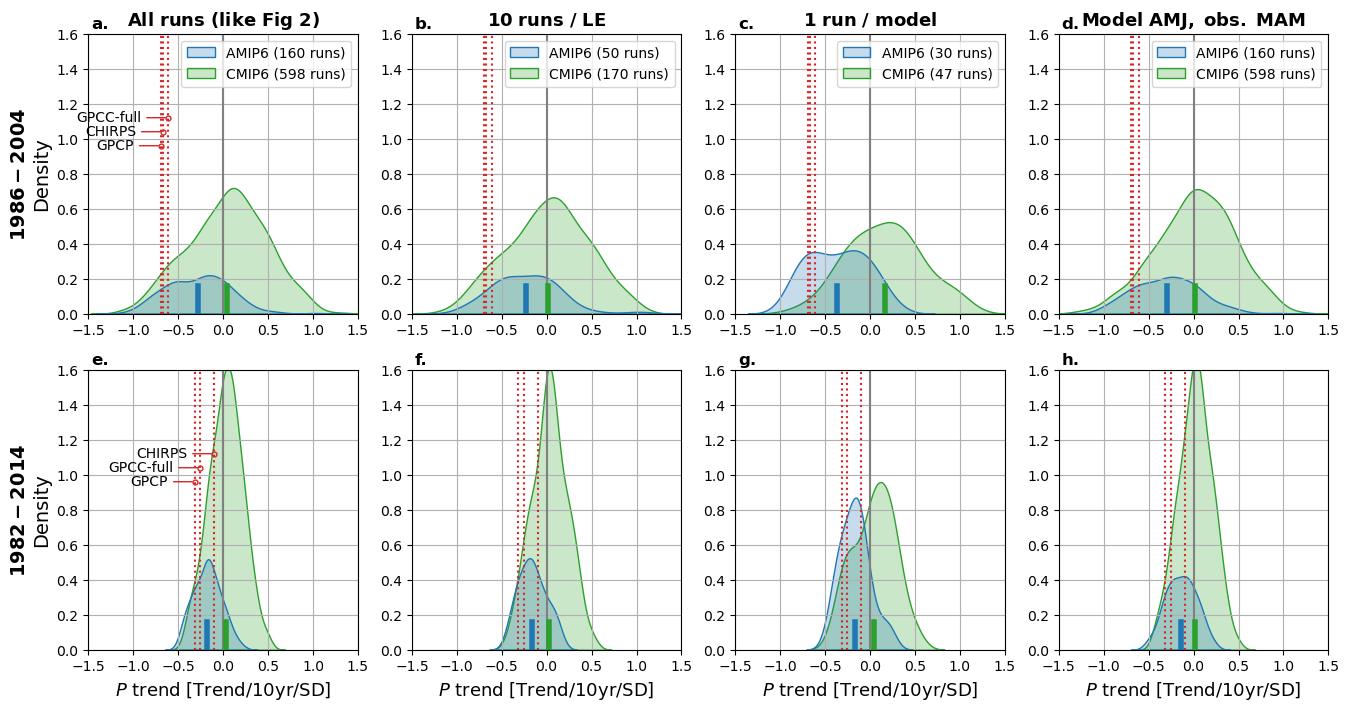

In [14]:
save_fig = True
output_fn = dir_list['figs']+'figureS6'


obs_mods = ['CHIRPS','GPCC-full','GPCP']

fig = plt.figure(figsize=(16,8))

ax_params = [{'dss_plot':dss,'seas':'MAM','title_str':r'$\mathbf{All\ runs\ (like\ Fig\ 2)}$'},
             {'dss_plot':dss_les,'nruns':10,'seas':'MAM','title_str':r'$\mathbf{10\ runs\ /\ LE}$'},
             {'dss_plot':dss,'nruns':1,'seas':'MAM','title_str':r'$\mathbf{1\ run\ /\ model}$'},
             {'dss_plot':dss_shift,'seas':'AMJ','title_str':r'$\mathbf{Model\ AMJ,\ obs.\ MAM}$'}]

ax_params = [*[{**{'start_year':1986,'end_year':2004},**ap} for ap in ax_params],
             *[{**{'start_year':1982,'end_year':2014},**ap} for ap in ax_params]]
ncols = 4

for x in np.arange(ncols,len(ax_params)):
    ax_params[x]['title_str'] = ''

for plt_idx in np.arange(0,len(ax_params)):
    ax = plt.subplot(2,ncols,plt_idx+1)
    ax = hist_plot(**ax_params[plt_idx],fig=fig,ax=ax,text_kwargs = {'fontsize':13},
                   plot_type = 'cv',obs_mods = obs_mods,label_obs=(plt_idx%ncols == 0),ylims=[0,1.6])
    
    ax.grid()
    
    if plt_idx < ncols:
        sns.move_legend(ax,'upper right',title=None)
    else:
        ax.legend([],[], frameon=False)
        
    if plt_idx < ncols:
        ax.set_xlabel('')
    if plt_idx % ncols > 0:
        ax.set_ylabel('')
    elif plt_idx % ncols == 0:
        ax.set_ylabel(r'$\mathbf{'+str(ax_params[plt_idx]['start_year'])+' - '+
                      str(ax_params[plt_idx]['end_year'])+'}$'+'\nDensity',
                      fontsize=14)
        
        
    # Subplot lettering
    ax.annotate(string.ascii_lowercase[plt_idx]+'.',
                        [0.01,1.01],xycoords='axes fraction',
                        va='bottom',ha='left',fontsize=12,fontweight='bold')


if save_fig:
    utility_print(output_fn)

### Supp Docs Figure S7
Like Figure S5, but using the Theil-Sen slope instead of the OLS slope.

/dx02/kschwarz/project_data/future_stability/figures/figureS7.pdf saved!
/dx02/kschwarz/project_data/future_stability/figures/figureS7.png saved!


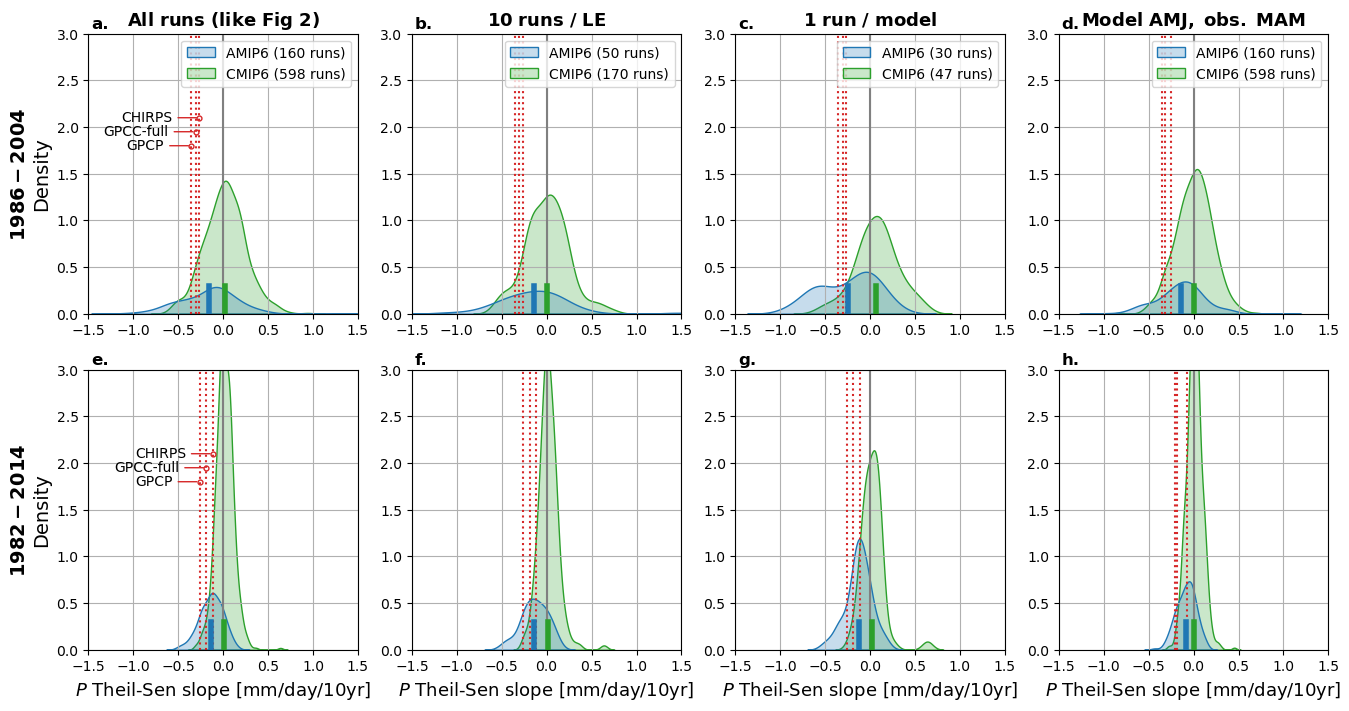

In [15]:
save_fig = True
output_fn = dir_list['figs']+'figureS7'

obs_mods = ['CHIRPS','GPCC-full','GPCP']

fig = plt.figure(figsize=(16,8))

ax_params = [{'dss_plot':dss,'seas':'MAM','title_str':r'$\mathbf{All\ runs\ (like\ Fig\ 2)}$'},
             {'dss_plot':dss_les,'nruns':10,'seas':'MAM','title_str':r'$\mathbf{10\ runs\ /\ LE}$'},
             {'dss_plot':dss,'nruns':1,'seas':'MAM','title_str':r'$\mathbf{1\ run\ /\ model}$'},
             {'dss_plot':dss_shift,'seas':'AMJ','title_str':r'$\mathbf{Model\ AMJ,\ obs.\ MAM}$'}]

ax_params = [*[{**{'start_year':1986,'end_year':2004},**ap} for ap in ax_params],
             *[{**{'start_year':1982,'end_year':2014},**ap} for ap in ax_params]]
ncols = 4

for x in np.arange(ncols,len(ax_params)):
    ax_params[x]['title_str'] = ''

for plt_idx in np.arange(0,len(ax_params)):
    ax = plt.subplot(2,ncols,plt_idx+1)
    ax = hist_plot(**ax_params[plt_idx],fig=fig,ax=ax,text_kwargs = {'fontsize':13},
                   plot_type = 'tslevels',obs_mods = obs_mods,label_obs=(plt_idx%ncols == 0),ylims=[0,3])
    
    ax.grid()
    
    if plt_idx < ncols:
        sns.move_legend(ax,'upper right',title=None)
    else:
        ax.legend([],[], frameon=False)
        
    if plt_idx < ncols:
        ax.set_xlabel('')
    if plt_idx % ncols > 0:
        ax.set_ylabel('')
    elif plt_idx % ncols == 0:
        ax.set_ylabel(r'$\mathbf{'+str(ax_params[plt_idx]['start_year'])+' - '+
                      str(ax_params[plt_idx]['end_year'])+'}$'+'\nDensity',
                      fontsize=14)
        
        
    # Subplot lettering
    ax.annotate(string.ascii_lowercase[plt_idx]+'.',
                        [0.01,1.01],xycoords='axes fraction',
                        va='bottom',ha='left',fontsize=12,fontweight='bold')


if save_fig:
    utility_print(output_fn)

### Supp Docs Figure S9
Subsetting by different categories of models by resolution.

Note, this requires raw precipitation files from ESGF. 

In [ ]:
df = get_filepaths()
df = df.query('varname == "pr" and freq == "Amon" and suffix == "HoAfrica" and exp == "historical"')
# Get one file per model
df = df.groupby('model').head(1)
# Add new columns
for v in ['lat','lon']:
    df['res_'+v] = np.nan

# Reset index
df = df.reset_index().drop('index',axis=1)

# Get grid spacing
for row_idx in range(len(df)):
    ds_tmp = xr.open_dataset(df.loc[row_idx,'path'])
    
    for v in ['lat','lon']:
        df.loc[row_idx,'res_'+v] =  np.round(ds_tmp[v].diff(v).mean().values,3)

# In degrees, the area of each grid cell
df['res_area'] = df['res_lat']*df['res_lon']

# Subset to just the columns needed here
df = df.query('run != "obs"').sort_values('res_area')[['model','res_lat','res_lon','res_area']]

# ICON-ESM-LR isn't processed right, drop it
df = df.loc[df.model != 'ICON-ESM-LR',:]

# Get categories of models by resolution 
res_limits = {'High res.\n(< 1 sq. deg.)':0,
              'Medium res.\n(1-3 sq. deg.)':1,
              'Low res.\n(>3 sq. deg.)':3}
df.loc[:,'restype'] = ''

for restype,res_limit in res_limits.items():
    df.loc[df['res_area']>=res_limit,'restype'] = restype

# Now get list of models by category
mods_by_res = {'All models':df['model'].values,**{typ:list(df.loc[df.restype==typ,'model'].values) for typ in res_limits}}

/home/kschwarz/projects/future_stability/figures/figureS9.pdf saved!
/home/kschwarz/projects/future_stability/figures/figureS9.png saved!


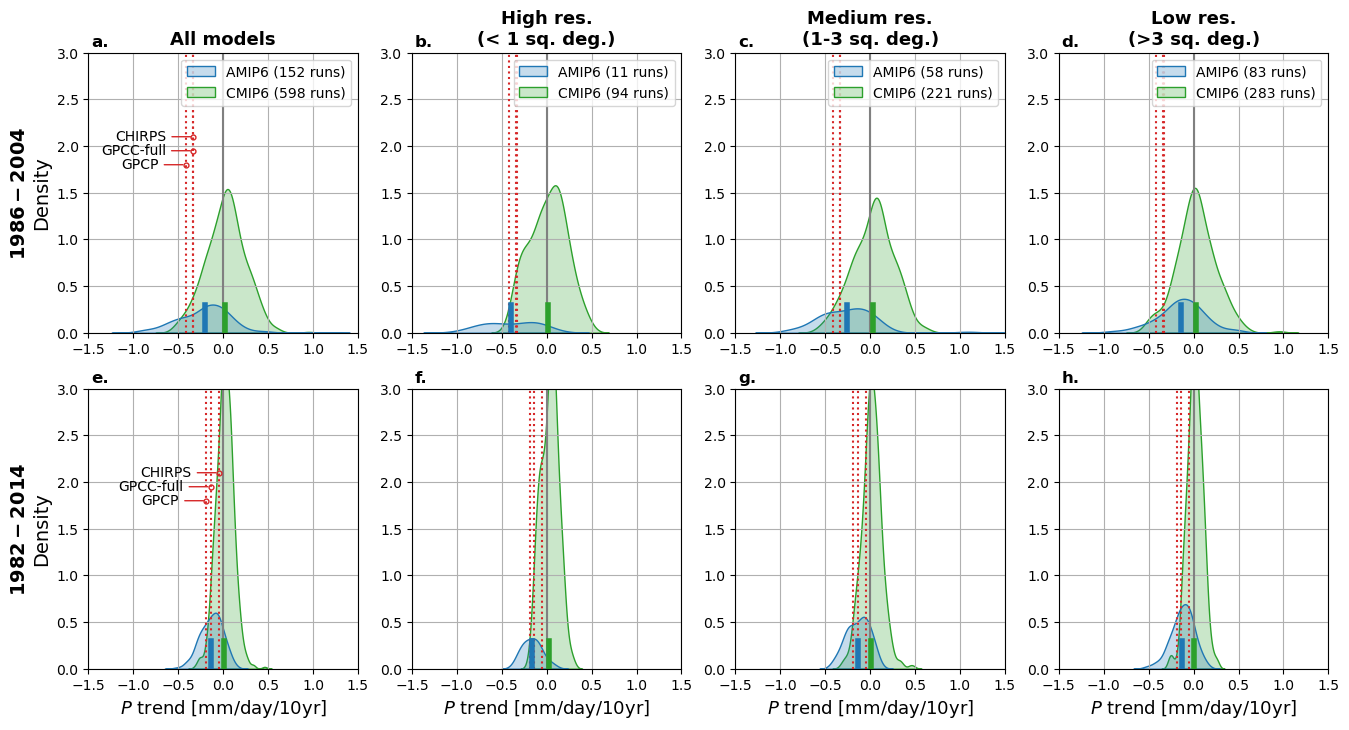

In [17]:
save_fig = True
output_fn = dir_list['figs']+'figureS9'

obs_mods = ['CHIRPS','GPCC-full','GPCP']

fig = plt.figure(figsize=(16,8))

ax_params = [{'dss_plot':{'obs':dss['obs'],**{exp:dss[exp].sel(model = [mod for mod in dss[exp].model.values if mod in mods_by_res[typ]])
                          for exp in ['amip','hist-ssp245']}},
              'seas':'MAM','title_str':typ}
            for typ in mods_by_res]

ax_params = [*[{**{'start_year':1986,'end_year':2004},**ap} for ap in ax_params],
             *[{**{'start_year':1982,'end_year':2014},**ap} for ap in ax_params]]
ncols = 4

for x in np.arange(ncols,len(ax_params)):
    ax_params[x]['title_str'] = ''

for plt_idx in np.arange(0,len(ax_params)):
    ax = plt.subplot(2,ncols,plt_idx+1)
    ax = hist_plot(**ax_params[plt_idx],fig=fig,ax=ax,text_kwargs = {'fontsize':13},
                   plot_type = 'levels',obs_mods = obs_mods,label_obs=(plt_idx%ncols == 0),ylims=[0,3])
    
    ax.grid()
    
    if plt_idx < ncols:
        sns.move_legend(ax,'upper right',title=None)
    else:
        ax.legend([],[], frameon=False)
        
    if plt_idx < ncols:
        ax.set_xlabel('')
    if plt_idx % ncols > 0:
        ax.set_ylabel('')
    elif plt_idx % ncols == 0:
        ax.set_ylabel(r'$\mathbf{'+str(ax_params[plt_idx]['start_year'])+' - '+
                      str(ax_params[plt_idx]['end_year'])+'}$'+'\nDensity',
                      fontsize=14)
        
        
    # Subplot lettering
    ax.annotate(string.ascii_lowercase[plt_idx]+'.',
                        [0.01,1.01],xycoords='axes fraction',
                        va='bottom',ha='left',fontsize=12,fontweight='bold')


if save_fig:
    utility_print(output_fn)

In [18]:
for typ,typ_idx in zip(mods_by_res,range(len(mods_by_res))):
    print('\n***** '+typ+' *****')
    for exp in ['hist-ssp245','amip']:
        print(exp+': '+str(ax_params[typ_idx]['dss_plot'][exp].sizes['model'])+' models')


***** All models *****
hist-ssp245: 48 models
amip: 28 models

***** High res.
(< 1 sq. deg.) *****
hist-ssp245: 7 models
amip: 4 models

***** Medium res.
(1-3 sq. deg.) *****
hist-ssp245: 24 models
amip: 13 models

***** Low res.
(>3 sq. deg.) *****
hist-ssp245: 17 models
amip: 11 models


### Supp Docs Figure S10
Precipitation trends vs. resolution 

In [19]:
ds_with_res = dss['amip'].copy()

In [20]:
ds_with_res['res'] = (['model'],np.squeeze(np.array([df.loc[df.model==mod,'res_area'].values 
 if mod in df.model.values else np.array([np.nan]) for mod in ds_with_res.model.values ])))

/home/kschwarz/projects/future_stability/figures/figureS10.pdf saved!
/home/kschwarz/projects/future_stability/figures/figureS10.png saved!


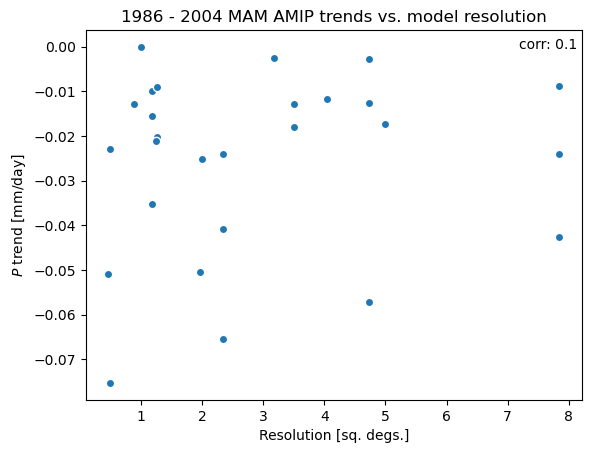

In [21]:
save_fig = True
#output_fn = dir_list['figs']+'figureSresB'
output_fn = dir_list['figs']+'figureS10'

ax = plt.subplot()
ds_with_res.sel(start_year=1986,end_year=2004,season='MAM').mean('run').plot.scatter(x='res',y='prtrend')
ax.set_xlabel('Resolution [sq. degs.]')
ax.set_ylabel(r'$P$ trend [mm/day]')
ax.set_title('1986 - 2004 MAM AMIP trends vs. model resolution')

ax.annotate('corr: '+str(xr.corr(ds_with_res.prtrend.mean('run'),ds_with_res.res,dim='model').round(2).sel(start_year=1986,end_year=2004,season='MAM').values),
            [0.99,0.95],xycoords='axes fraction',ha='right')

if save_fig:
    utility_print(output_fn)